In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

In [17]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def generate_2Dgrid(minimum1, maximum1, minimum2, maximum2, N):
    grid1 = np.linspace(minimum1, maximum1, N, dtype = np.float32)
    grid2 = np.linspace(minimum2, maximum2, N, dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(N**2), requires_grad = True)
    y = torch.tensor(y0.reshape(N**2), requires_grad = True)
    return x, y

def plot_form(x, y, z, N):
    return map(lambda t: t.reshape(N,N).cpu().detach().numpy(), (x, y, z))


# Solving the Inviscid Burgers equation

Here we solve the inviscid Burgers Equation

$$\partial_t u(t,x) = u(t,x) \partial_x u(t,x),$$

with the initial conditions

$$u(0,x) = f(x) = \begin{cases}1 && \text{if }x < 0\\1-x && \text{if }0\leq x \leq 1\\0 && \text{if }1< x \\\end{cases}$$

We impose the initial conditions by weak enforcement.

<br>

In [52]:
# The ODE solution will be modelled as a NN with 1 hidden layer of 40 nodes 
# and output 2 values
class InviscidBurgers(nn.Module):
    def __init__(self):
        super(InviscidBurgers, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 20),  #the input in 28*28
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, t, x):
        tx = torch.stack((t,x), 1)
        #bdry = (abs(x) - 1).reshape(len(x), 1)
        return self.net(tx) #* bdry

# The loss function that will be used to train the NN will be constructed
# out of the DE
def g(x):
    if x < -1:
        return 0
    elif x < 0:
        return x+1
    elif x < 1:
        return 1-x
    else:
        return 0


resolution = 600
class InviscidBurgersLoss(nn.Module):
    def __init__(self, approx_sol):
        super(InviscidBurgersLoss, self).__init__()
        self.approx_sol = approx_sol
        
    def forward(self, t, x):

       # global test1, test2, test3, test4
      
        u   =  self.approx_sol(t, x).squeeze()
        u_t = gradients(u, t)
        u_x = gradients(u, x)

        eq = u_t + u* u_x

        # loss function associated with satisfying DE        
        eq_loss = (eq)**2



        #define the initial values of t,x
        tinitial=torch.zeros(resolution)
        xinitial = torch.as_tensor([x[resolution*i] for i in range(resolution)])

        xbc1 = -2*torch.ones(resolution)
        tbc1 = torch.as_tensor([t[resolution*i] for i in range(resolution)])
        xbc2 = 2*torch.ones(resolution)
        tbc2 = torch.as_tensor([t[resolution*i] for i in range(resolution)])

        ic = torch.flatten(self.approx_sol(tinitial, xinitial))
        bc1 = torch.flatten(self.approx_sol(tbc1, xbc1))
        bc2 = torch.flatten(self.approx_sol(tbc2, xbc2))
        ic_loss = (ic - torch.as_tensor(list(map(g, xinitial))))**2 + (bc1 - 0)**2 + (bc2 - 0)**2

        
       # test1=eq_loss
       ## test3=u_x
        #test2= ic_loss
        #test4=u*u_x

        return torch.mean(eq_loss)+resolution*torch.sum(ic_loss) #torch.mean(torch.cat((eq_loss, 2*ic_loss),dim=0)) #torch.mean(eq_loss.append() ) #

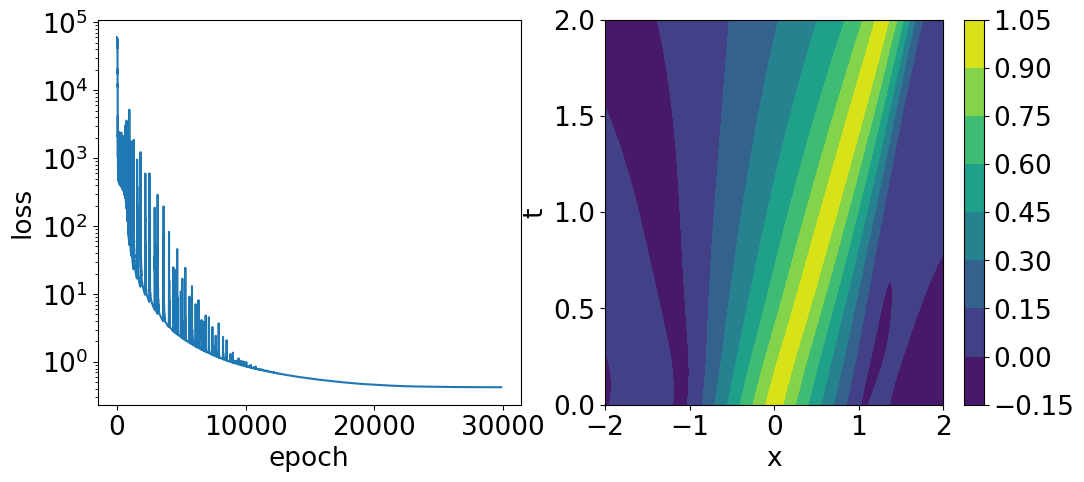

In [53]:
pde      = InviscidBurgers()
pde_loss = InviscidBurgersLoss(pde)
loss_hist = []

t, x = generate_2Dgrid(0, 2, -2, 2, resolution)
optimizer = optim.Adam(pde.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

################## Training and Plotting ##################
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

p = None

for it in range(30000):
    try:
        optimizer.zero_grad()

        loss = pde_loss(t, x)
        loss_hist.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if  it %100 == 0:
            t_plot, x_plot, u_plot = plot_form(x, t, pde(t, x), resolution)
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('t')
            p = ax2.contourf(t_plot, x_plot, u_plot)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        break

fig.colorbar(p)

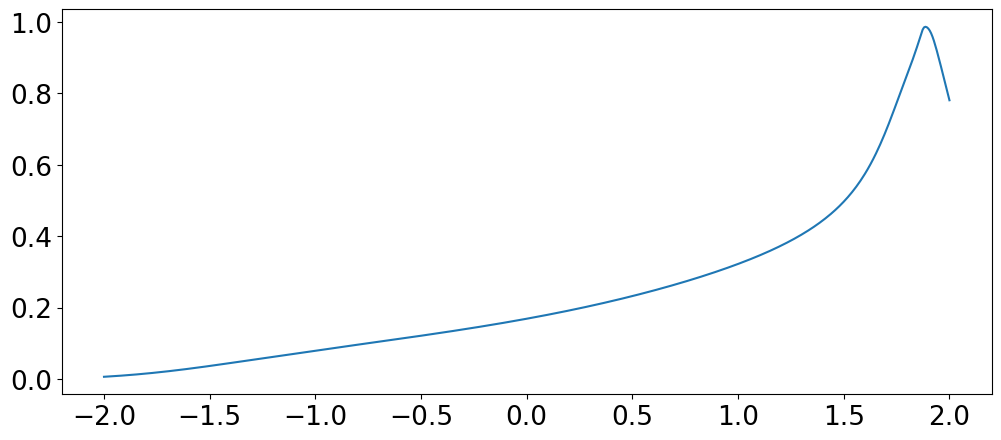

In [54]:
u = pde(3*torch.ones(resolution), torch.linspace(-2,2,resolution))
fig, (ax1) = plt.subplots(1,1, figsize = (12, 5));
ax1.plot(torch.linspace(-2,2,resolution), u.detach().numpy())